In [2]:
from scprint import scPrint
from scdataloader import Preprocessor

from bengrn import BenGRN, get_sroy_gt, FILEDIR
import scanpy as sc

from anndata.utils import make_index_unique
from bengrn import compute_genie3, get_GT_db
from grnndata import utils as grnutils
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

→ connected lamindb: jkobject/scprint


In [3]:
from grnndata import GRNAnnData

import sys
sys.path.append("../tools/DeepSEM")

from src.DeepSEM_cell_type_test_specific_GRN_model import celltype_GRN_model as test_celltype_GRN_model

class DotDict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

import scipy.sparse

def run_deepsem(adata):
    import random
    import string

    def generate_random_hash(length=3):
        """Generate a random hash of specified length."""
        characters = string.ascii_letters + string.digits
        return ''.join(random.choice(characters) for _ in range(length))

    random_hash = generate_random_hash()
    opt = DotDict({
        'beta': 0.01,
        'alpha': 1,
        'K1': 1,
        'K2': 2,
        'K': 1,
        'net_file': "",
        'n_epochs': 50,
        'n_hidden': 128,
        'gamma': 0.95,
        'lr': 1e-4,
        'lr_step_size': 0.99,
        'batch_size': 64,
        'data_file': "/tmp/deepsem_"+random_hash+".h5ad",
        'save_name': "/tmp/deepsem/",
        'task': "celltype_GRN"
    })
    print(random_hash)
    if scipy.sparse.issparse(adata.X):
        adata.X = adata.X.toarray()
    adata.write("/tmp/deepsem_"+random_hash+".h5ad")
    model = test_celltype_GRN_model(opt)
    net = model.train_model()
    grn = GRNAnnData(adata.copy(), grn=net)
    del net
    return grn

In [4]:
#genes = torch.load('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']

genes = torch.load('../data/temp/vbd8bavn/epoch=17-step=90000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']

preprocessor = Preprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
NUM_GENES = 5000
MAXCELLS = 1024

# han / full


In [6]:
metrics = {}

In [5]:
preadata = get_sroy_gt(get="han", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
adata = adata[:, adata.var.index.isin(genes)]
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 5520 renamining
filtered out 0 cells, 5520 renamining
No ENSG genes found, assuming gene symbols...
Removed 0 genes.
startin QC
Seeing 151 outliers (2.74% of total dataset):
done


(GRnnData object with n_obs × n_vars = 5520 × 7465
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 8463 elements,
 31)

In [7]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.highly_variable]
sc.pp.normalize_total(subadata)
sc.pp.log1p(subadata)
sc.pp.scale(subadata, zero_center=True, max_value=None)
grn = run_deepsem(subadata)
grn.var['symbol'] = make_index_unique(
    grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']

tdT
save dir exist


/home/ml4ig1/Documents code/scPRINT/notebooks/../tools/DeepSEM/src/DeepSEM_cell_type_test_specific_GRN_model.py:49: RuntimeWarning: Mean of empty slice.
  means.append(tmp[tmp != 0].mean())
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch: 1 0.26330129336565733 mse_loss: 0.22132632602006197 kl_loss: 0.04126456886297092 sparse_loss: 0.0007103946190909483
epoch: 2 0.24353623110800982 mse_loss: 0.19486601743847132 kl_loss: 0.04776330559980124 sparse_loss: 0.0009069028092199005
epoch: 4 0.1509982319548726 mse_loss: 0.10285274311900139 kl_loss: 0.04717105231247842 sparse_loss: 0.0009744327035150491
epoch: 5 0.1501442976295948 mse_loss: 0.10076331766322255 kl_loss: 0.04836421459913254 sparse_loss: 0.0010167605360038579
epoch: 7 0.13895735889673233 mse_loss: 0.0889685619622469 kl_loss: 0.04895418765954673 sparse_loss: 0.0010346095950808376
epoch: 8 0.1389147350564599 mse_loss: 0.08875014586374164 kl_loss: 0.04912365926429629 sparse_loss: 0.0010409261449240148
epoch: 10 0.12902327021583915 mse_loss: 0.07872997457161546 kl_loss: 0.04925051564350724 sparse_loss: 0.0010427780653117225
epoch: 11 0.12923306412994862 mse_loss: 0.07897752989083529 kl_loss: 0.049213201040402055 sparse_loss: 0.0010423317435197532
epoch: 13 0.12094

precision:  0.027305461092218444 
recall:  0.9970119521912351 
random precision: 0.02738729564094637


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1987.59it/s]

Average Precision (AP):  0.029699034971487407
Area Under Precision-Recall Curve (AUPRC):  0.029598807914312943
EPR: 1.5881208305674783


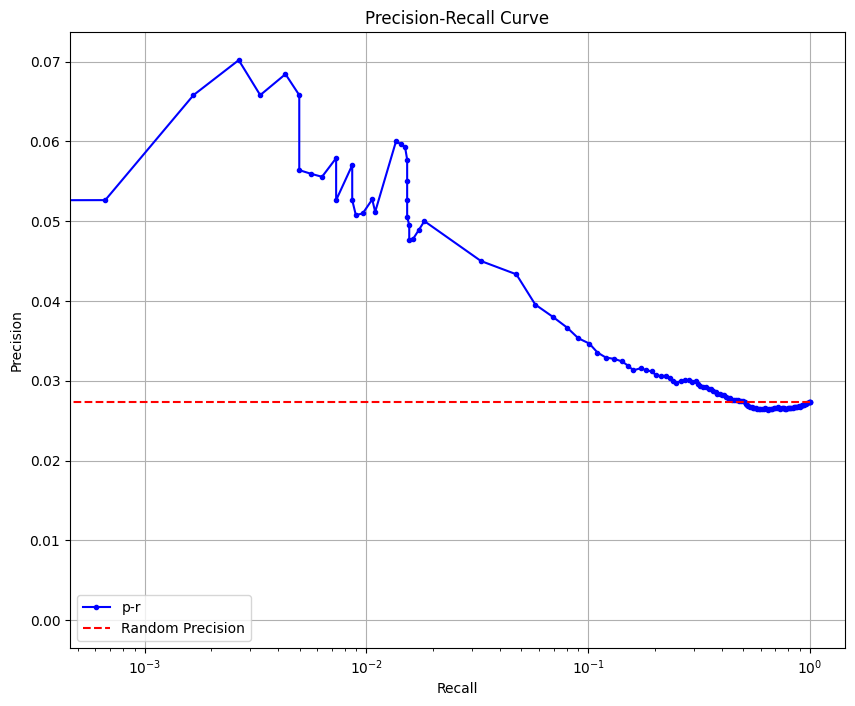

In [8]:
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['deepsem_han'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment
Top central genes: []


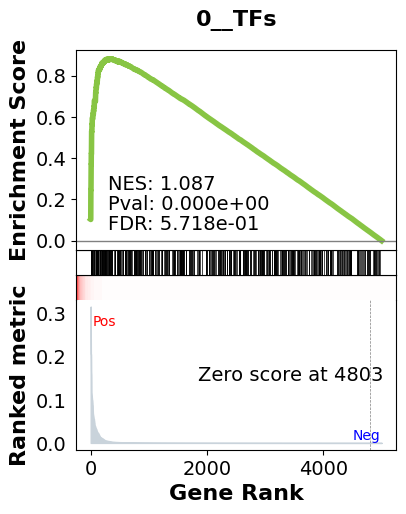

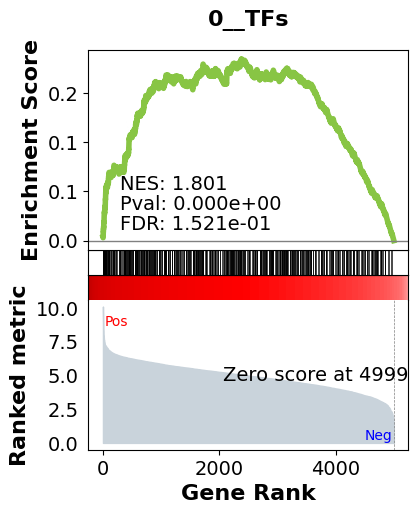

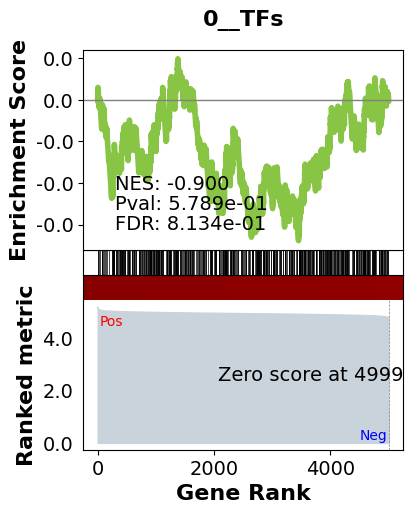

_________________________________________
TF specific enrichment


found some significant results for  18.867924528301888 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3764 genes
intersection pct: 0.7528
precision:  0.0015159632226418483 
recall:  0.9999068641147434 
random precision: 0.0015161044263697398


 98%|█████████▊| 126/128 [00:03<00:00, 35.80it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:03<00:00, 36.72it/s]


Average Precision (AP):  0.0018883204854496848
Area Under Precision-Recall Curve (AUPRC):  0.0018060869702243268
EPR: 5.54235527488187


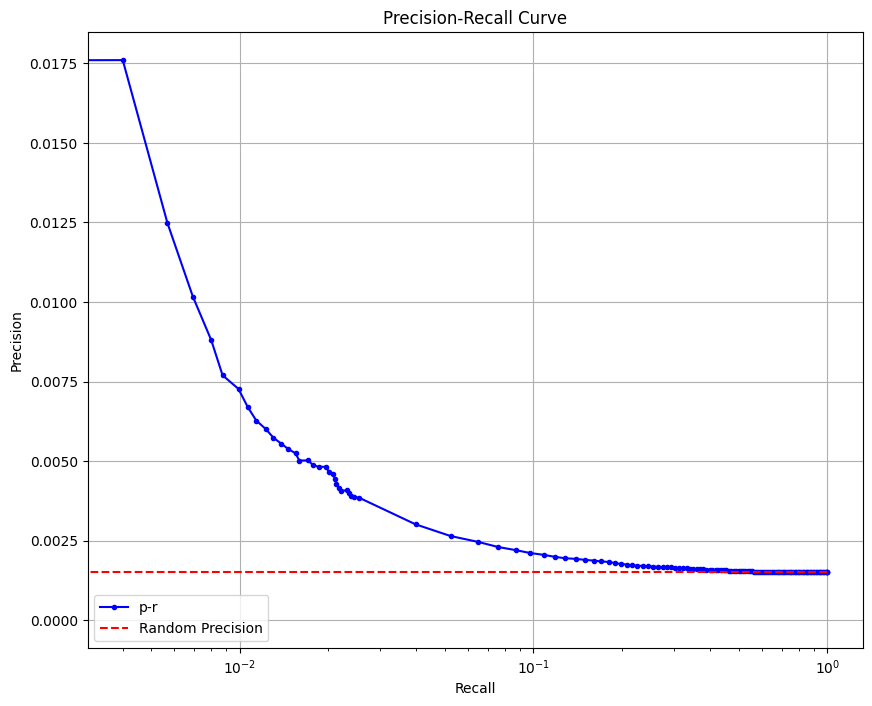

In [9]:
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['deepsem_han_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.2533531096463195 
recall:  0.9995187865722205 
random precision: 0.25347508526095464


 74%|███████▍  | 95/128 [00:00<00:00, 328.77it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 314.67it/s]


Average Precision (AP):  0.24940243814610946
Area Under Precision-Recall Curve (AUPRC):  0.24934405625719908
EPR: 0.9682915492247204


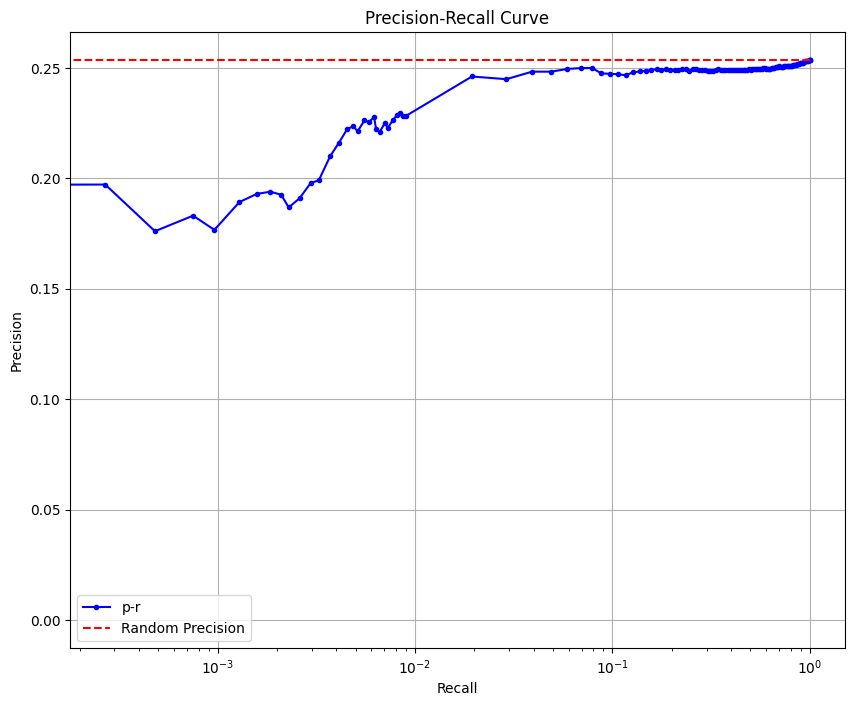

In [10]:
preadata = get_sroy_gt(get="han", species="human", gt="chip")
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['deepsem_han_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.07581693329816405 
recall:  0.998577723891907 
random precision: 0.07592491949717377


 98%|█████████▊| 126/128 [00:00<00:00, 425.09it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 412.82it/s]


Average Precision (AP):  0.0852858543727235
Area Under Precision-Recall Curve (AUPRC):  0.08511216884056125
EPR: 1.3600832411937898


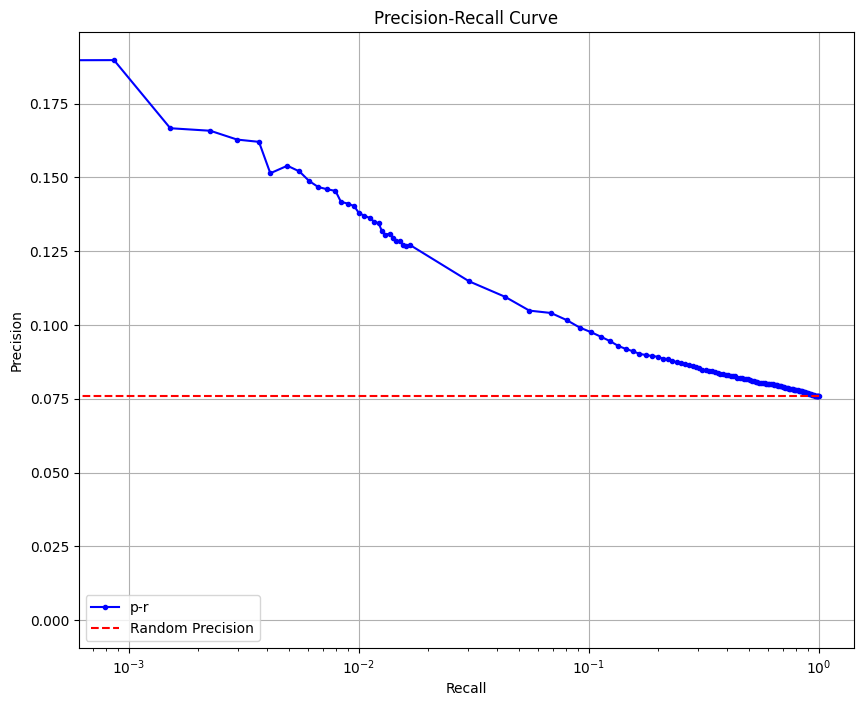

In [11]:
preadata = get_sroy_gt(get="han", species="human", gt="ko")
metrics['deepsem_han_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

## trial with my own ESC

In [12]:
preadata = get_sroy_gt(get="mine", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 115 renamining
filtered out 0 cells, 115 renamining
Removed 0 genes.
startin QC
Seeing 104 outliers (90.43% of total dataset):
done


(GRnnData object with n_obs × n_vars = 115 × 28490
     obs: 'organism_ontology_term_id'
     var: 'ensembl_id'
     varp: 'GRN'
     with a grn of 11565 elements,
 35)

4Vb
save dir exist
epoch: 1 0.9104321002960205 mse_loss: 0.8863225877285004 kl_loss: 0.02378240553662181 sparse_loss: 0.00032706228375900537
epoch: 2 0.9103941023349762 mse_loss: 0.8862714767456055 kl_loss: 0.02378687303280458 sparse_loss: 0.00033572950633242726
epoch: 4 0.819663941860199 mse_loss: 0.7948977649211884 kl_loss: 0.024414085026364774 sparse_loss: 0.000352059185388498
epoch: 5 0.8183291852474213 mse_loss: 0.7935504913330078 kl_loss: 0.024412669125013053 sparse_loss: 0.000366024425602518
epoch: 7 0.7231567800045013 mse_loss: 0.6975902915000916 kl_loss: 0.02518637594766915 sparse_loss: 0.0003801073180511594
epoch: 8 0.7244558334350586 mse_loss: 0.6988702118396759 kl_loss: 0.025185266509652138 sparse_loss: 0.00040035159327089787
epoch: 10 0.6361226737499237 mse_loss: 0.6096567511558533 kl_loss: 0.026043012156151235 sparse_loss: 0.00042284429946448654
epoch: 11 0.6241084337234497 mse_loss: 0.5976050794124603 kl_loss: 0.02604560984764248 sparse_loss: 0.0004577261279337108
epoch:

  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 2504.79it/s]

Average Precision (AP):  0.034478502194550134
Area Under Precision-Recall Curve (AUPRC):  0.03441874758233565
EPR: 0.8611170915599684


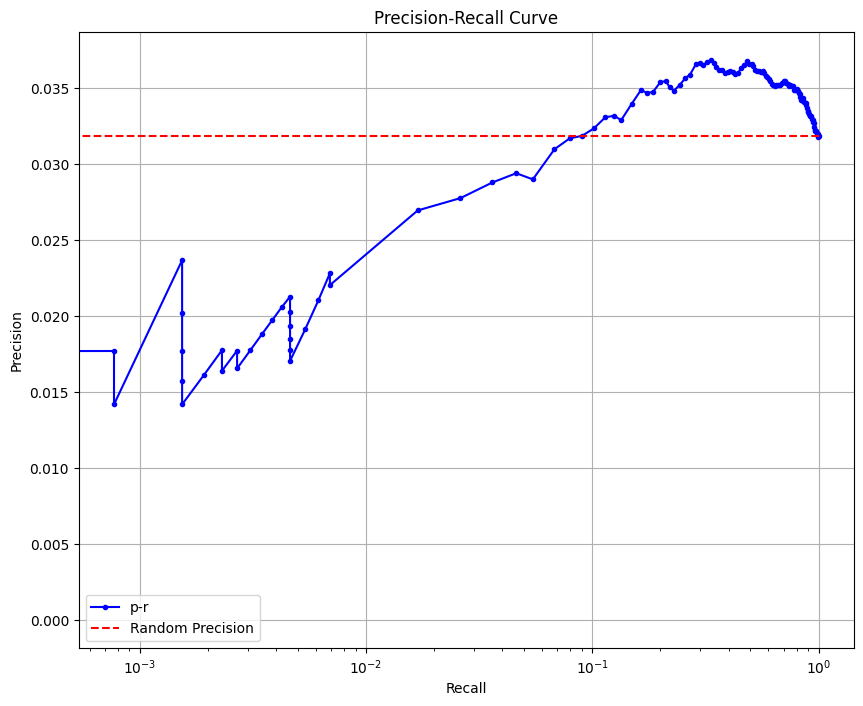

base enrichment
Top central genes: []


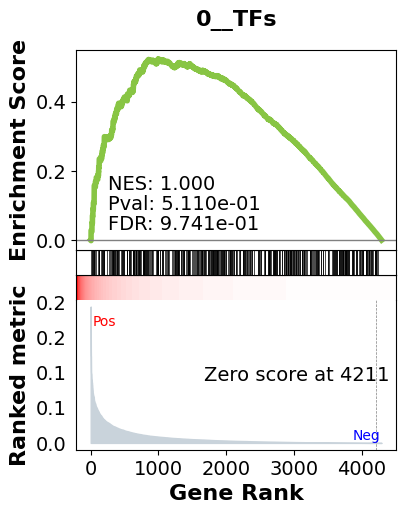

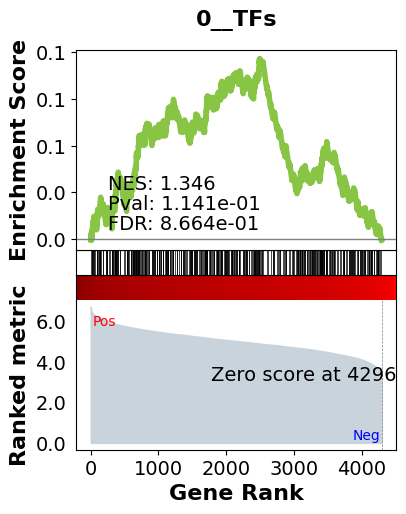

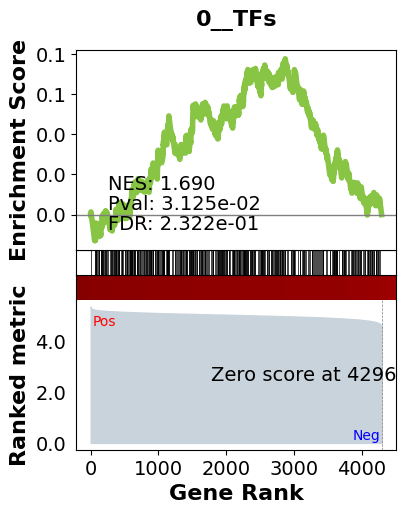

_________________________________________
TF specific enrichment
found some significant results for  5.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2833 genes
intersection pct: 0.6592971840819176
precision:  0.001520119016993026 
recall:  0.9999180126260556 
random precision: 0.001520243657778283


 95%|█████████▍| 121/128 [00:01<00:00, 72.43it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 72.48it/s]


Average Precision (AP):  0.0015333917872562227
Area Under Precision-Recall Curve (AUPRC):  0.001532853820886019
EPR: 1.0788667650364132


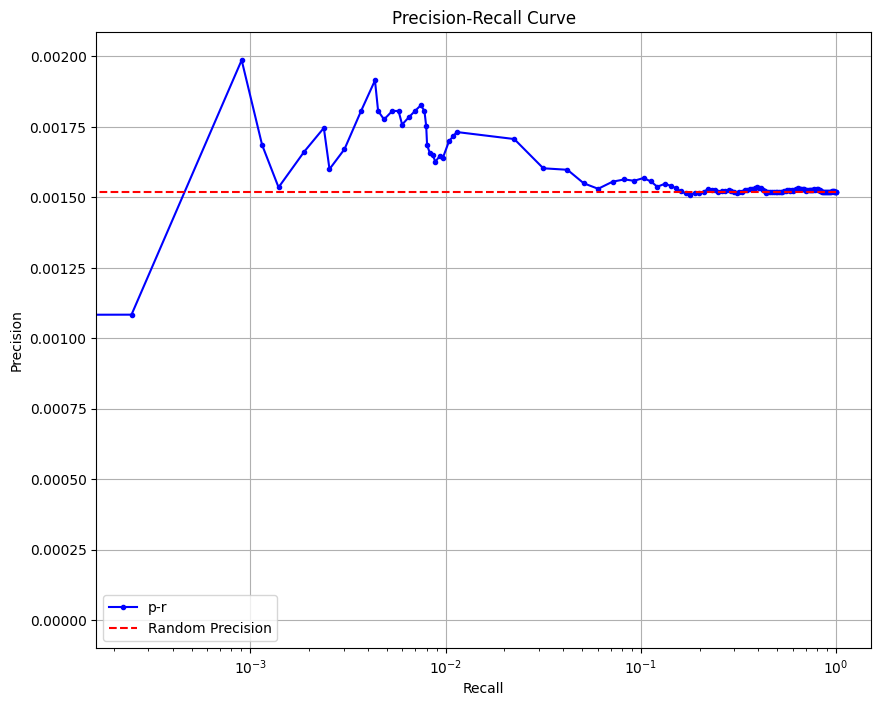

In [13]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
sc.pp.normalize_total(subadata)
sc.pp.log1p(subadata)
sc.pp.scale(subadata, zero_center=True, max_value=None)
grn = run_deepsem(subadata)

grn.var['symbol'] = make_index_unique(
    grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['deepsem_mine'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['deepsem_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

base enrichment
Top central genes: []


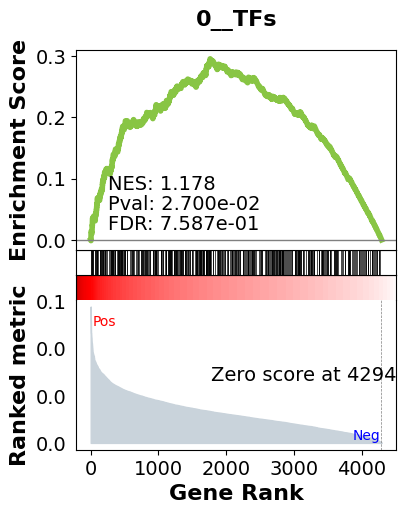

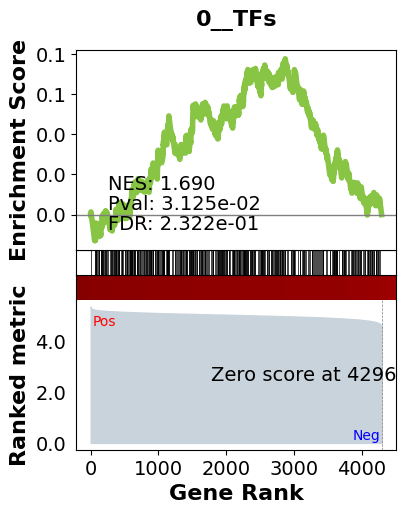

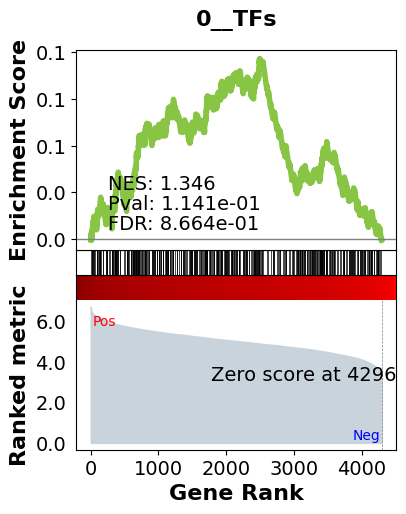

_________________________________________
TF specific enrichment
found some significant results for  7.5 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2833 genes
intersection pct: 0.6592971840819176
precision:  0.001520119016993026 
recall:  0.9999180126260556 
random precision: 0.001520243657778283


 99%|█████████▉| 127/128 [00:01<00:00, 72.00it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 71.57it/s]


Average Precision (AP):  0.0015045296043676038
Area Under Precision-Recall Curve (AUPRC):  0.0015040358260267738
EPR: 0.9706609689532676


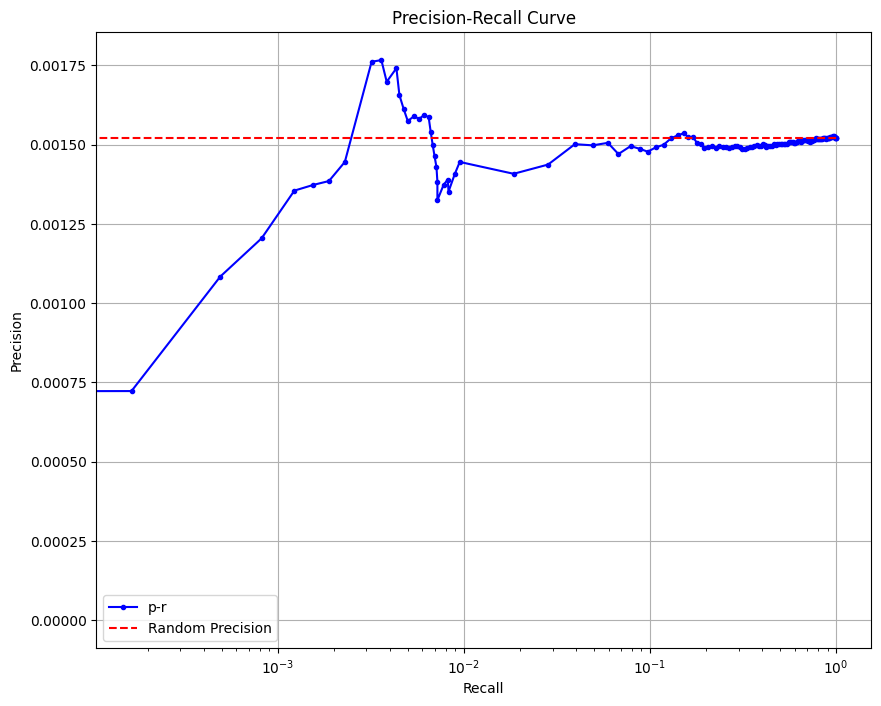

In [14]:
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['deepsem_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

lyi
save dir exist
epoch: 1 1.0117132365703583 mse_loss: 0.9882104098796844 kl_loss: 0.023164933518273756 sparse_loss: 0.0003378558612894267
epoch: 2 1.015483021736145 mse_loss: 0.9919267296791077 kl_loss: 0.02318919230310712 sparse_loss: 0.0003670998994493857
epoch: 4 0.9777038097381592 mse_loss: 0.9538528323173523 kl_loss: 0.023452887340681627 sparse_loss: 0.00039807359280530363
epoch: 5 0.976612389087677 mse_loss: 0.952663242816925 kl_loss: 0.02351547386206221 sparse_loss: 0.00043365512101445347
epoch: 7 0.8517782688140869 mse_loss: 0.826870858669281 kl_loss: 0.024433030048385262 sparse_loss: 0.0004743585304822773
epoch: 8 0.8399676382541656 mse_loss: 0.814566045999527 kl_loss: 0.02485841466113925 sparse_loss: 0.0005431637982837856
epoch: 10 0.5923589468002319 mse_loss: 0.5643044412136078 kl_loss: 0.02743877179455012 sparse_loss: 0.0006157185998745263
epoch: 11 0.5649804472923279 mse_loss: 0.5353457927703857 kl_loss: 0.028914083493873477 sparse_loss: 0.0007205836300272495
epoch: 13 

  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 3974.23it/s]

Average Precision (AP):  0.03261228845958016
Area Under Precision-Recall Curve (AUPRC):  0.03251177646453238
EPR: 1.0015126987201286


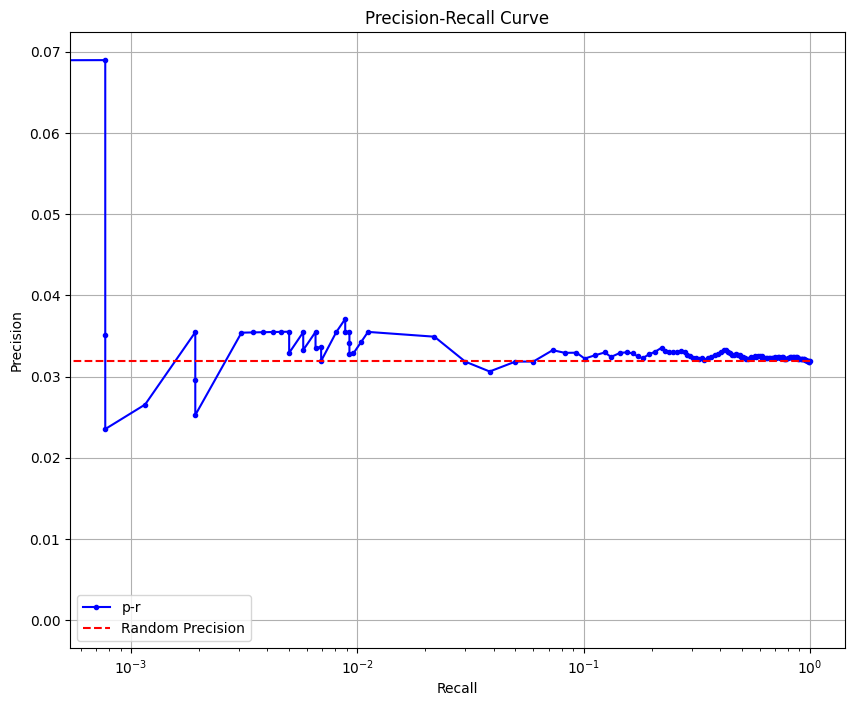

In [16]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]

sc.pp.normalize_total(subadata)
sc.pp.log1p(subadata)
sc.pp.scale(subadata, zero_center=True, max_value=None)
grn = run_deepsem(subadata)
grn.var['symbol'] = make_index_unique(
    grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['deepsem_mine'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment
Top central genes: []


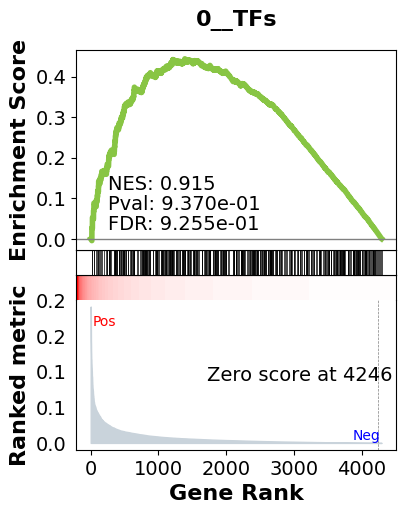

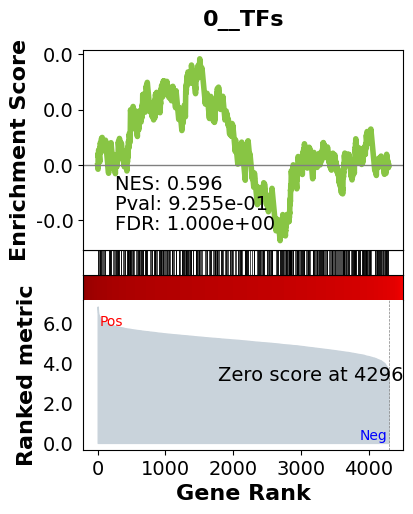

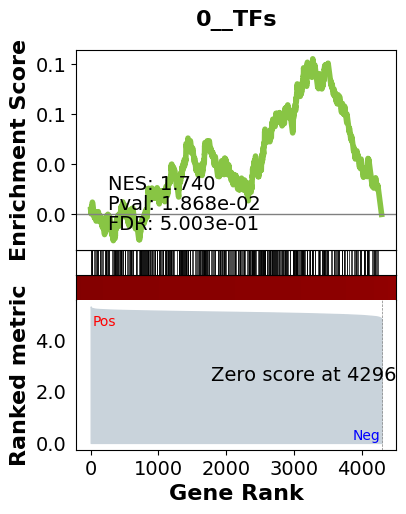

_________________________________________
TF specific enrichment
found some significant results for  5.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2833 genes
intersection pct: 0.6592971840819176
precision:  0.001520119016993026 
recall:  0.9999180126260556 
random precision: 0.001520243657778283


 95%|█████████▍| 121/128 [00:01<00:00, 69.69it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 71.83it/s]


Average Precision (AP):  0.0015545869347883665
Area Under Precision-Recall Curve (AUPRC):  0.0015534431205924662
EPR: 1.2413088026042838


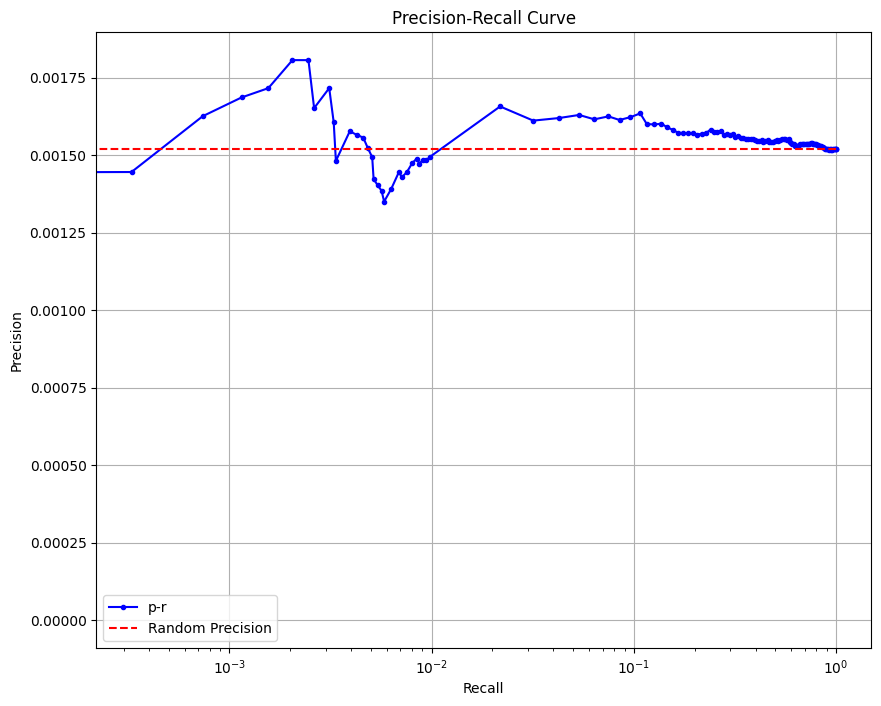

In [17]:
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['genie3_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

## trial with the other two mouse dataset

In [18]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.mTF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 2369 renamining
filtered out 0 cells, 2369 renamining
No ENSG genes found, assuming gene symbols...
Removed 0 genes.
startin QC
Seeing 91 outliers (3.84% of total dataset):
done


(GRnnData object with n_obs × n_vars = 2369 × 6618
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 7162 elements,
 31)

6Dq
save dir exist


/home/ml4ig1/Documents code/scPRINT/notebooks/../tools/DeepSEM/src/DeepSEM_cell_type_test_specific_GRN_model.py:49: RuntimeWarning: Mean of empty slice.
  means.append(tmp[tmp != 0].mean())
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch: 1 0.24411583598703146 mse_loss: 0.20520930457860231 kl_loss: 0.03817100136075169 sparse_loss: 0.000735526697098976
epoch: 2 0.2196965292096138 mse_loss: 0.1755631761625409 kl_loss: 0.043158409651368856 sparse_loss: 0.0009749376076797489
epoch: 4 0.12916431901976466 mse_loss: 0.08000752702355385 kl_loss: 0.04810761578846723 sparse_loss: 0.0010491758366697468
epoch: 5 0.1289600902236998 mse_loss: 0.078991120448336 kl_loss: 0.048888537217862904 sparse_loss: 0.0010804317353176884
epoch: 7 0.12063791137188673 mse_loss: 0.06998000876046717 kl_loss: 0.04956863773986697 sparse_loss: 0.0010892644131672569
epoch: 8 0.12199522834271193 mse_loss: 0.07145064952783287 kl_loss: 0.04945688066072762 sparse_loss: 0.0010876990636461414
epoch: 10 0.11482133390381932 mse_loss: 0.06405008235014975 kl_loss: 0.0496853650547564 sparse_loss: 0.0010858887762879021
epoch: 11 0.1145865498110652 mse_loss: 0.0639492014888674 kl_loss: 0.049554264871403575 sparse_loss: 0.0010830852115759626
epoch: 13 0.10819140

  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1300.73it/s]

Average Precision (AP):  0.06328316996693076
Area Under Precision-Recall Curve (AUPRC):  0.06324904153365038
EPR: 2.0915738193559457


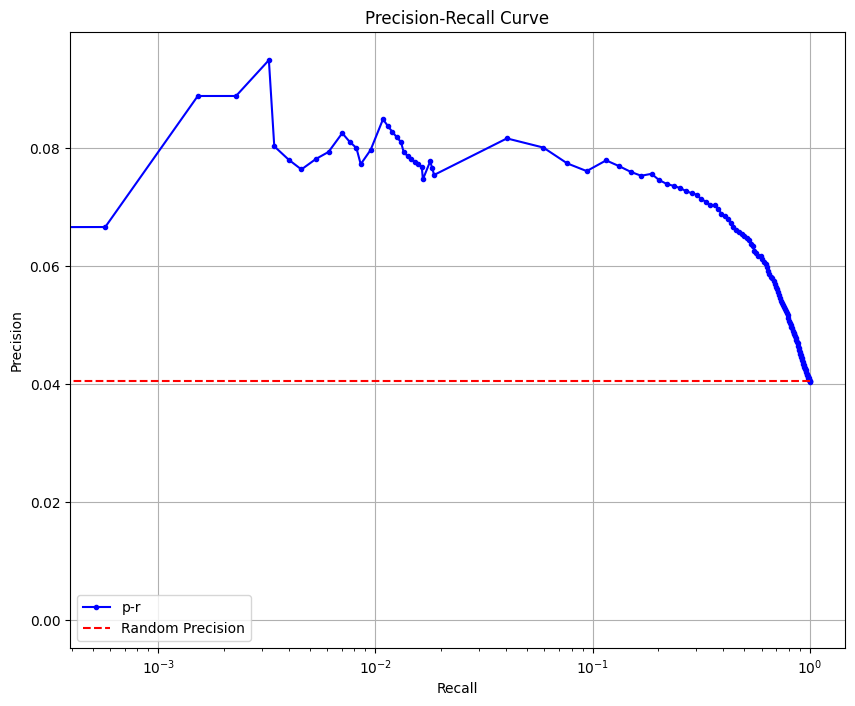

In [19]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]

sc.pp.normalize_total(subadata)
sc.pp.log1p(subadata)
sc.pp.scale(subadata, zero_center=True, max_value=None)
grn = run_deepsem(subadata)
grn.var['symbol'] = make_index_unique(
    grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['deepsem_tran'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.19809205251553416 
recall:  0.9996206972848247 
random precision: 0.19816721787933453


 72%|███████▏  | 92/128 [00:00<00:00, 452.42it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 451.18it/s]


Average Precision (AP):  0.19249175451912165
Area Under Precision-Recall Curve (AUPRC):  0.19247074531219488
EPR: 1.0276752262741708


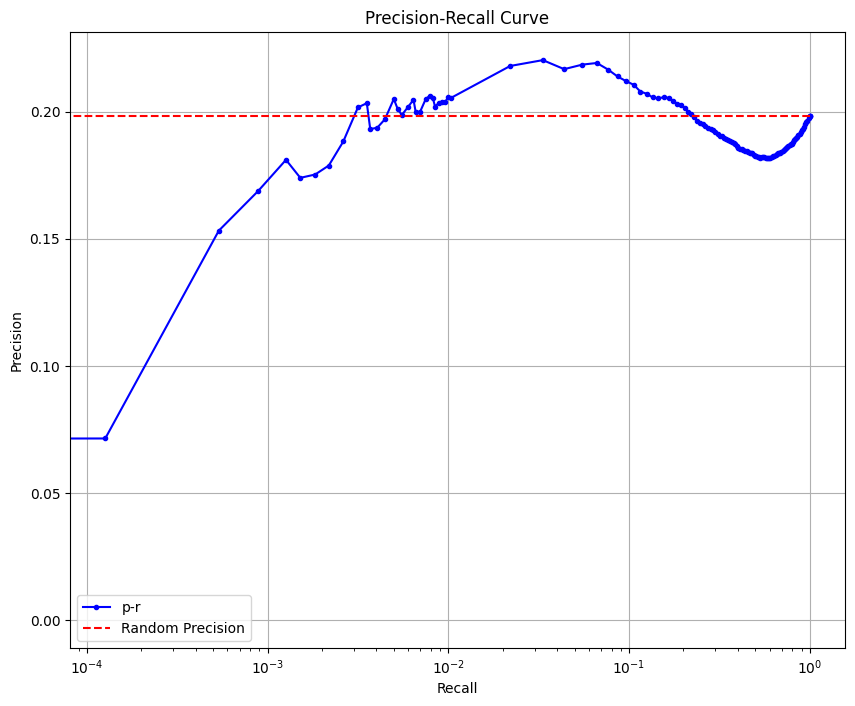

In [20]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="chip")
metrics['deepsem_tran_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.0818837156028978 
recall:  0.9985377883503197 
random precision: 0.08200362225467457


 75%|███████▌  | 96/128 [00:00<00:00, 317.29it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 315.95it/s]


Average Precision (AP):  0.10313917344705781
Area Under Precision-Recall Curve (AUPRC):  0.1031100817258375
EPR: 1.582492367084701


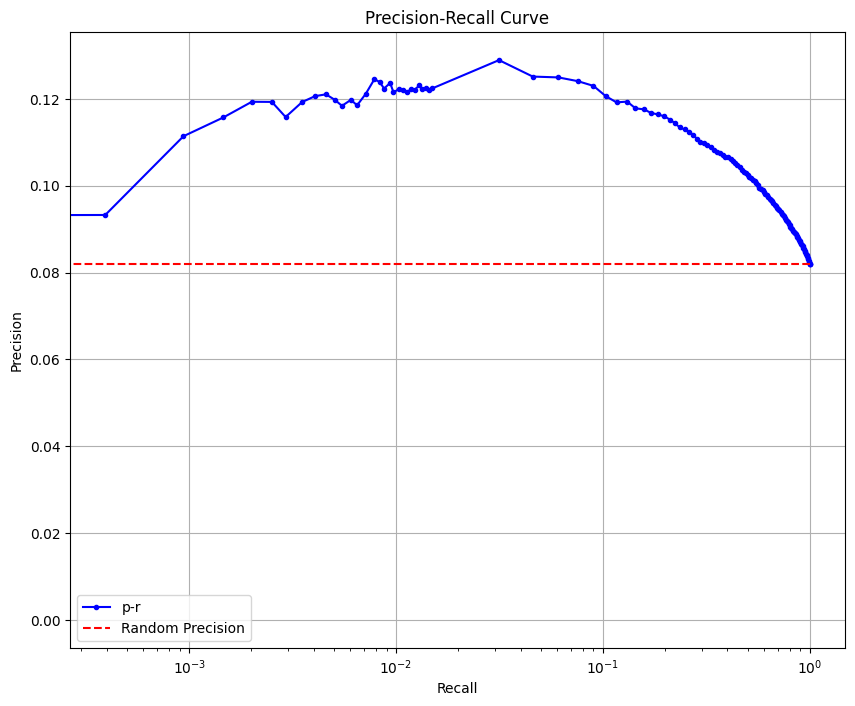

In [21]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="ko")
metrics['deepsem_tran_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

# zhao

In [22]:
preadata = get_sroy_gt(get="zhao", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.mTF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 36199 renamining
filtered out 63 cells, 36136 renamining
No ENSG genes found, assuming gene symbols...
Removed 0 genes.
startin QC
Seeing 768 outliers (2.13% of total dataset):
done


(GRnnData object with n_obs × n_vars = 36199 × 8442
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 9019 elements,
 34)

bpw
save dir exist


/home/ml4ig1/Documents code/scPRINT/notebooks/../tools/DeepSEM/src/DeepSEM_cell_type_test_specific_GRN_model.py:49: RuntimeWarning: Mean of empty slice.
  means.append(tmp[tmp != 0].mean())
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch: 1 0.30380580946803093 mse_loss: 0.26404888555407524 kl_loss: 0.03910293374792673 sparse_loss: 0.0006539911337313242
epoch: 2 0.285093080252409 mse_loss: 0.2396743567660451 kl_loss: 0.044612324447371066 sparse_loss: 0.000806406435003737
epoch: 4 0.16779422294348478 mse_loss: 0.12149521568790078 kl_loss: 0.04543595854192972 sparse_loss: 0.0008630428783362731


epoch: 5 0.1677513336762786 mse_loss: 0.12024938268586993 kl_loss: 0.04660313145723194 sparse_loss: 0.0008988114059320651
epoch: 7 0.1539356391876936 mse_loss: 0.10591499088332057 kl_loss: 0.04710911214351654 sparse_loss: 0.0009115325738093816
epoch: 8 0.15400228276848793 mse_loss: 0.1058719428256154 kl_loss: 0.047214766032993793 sparse_loss: 0.0009155686348094605
epoch: 10 0.14261840470135212 mse_loss: 0.09447842836380005 kl_loss: 0.04722200985997915 sparse_loss: 0.0009179627486446407
epoch: 11 0.14276406448334455 mse_loss: 0.09458993095904589 kl_loss: 0.04725434083957225 sparse_loss: 0.0009197858453262597
epoch: 13 0.1334967538714409 mse_loss: 0.08532126666978002 kl_loss: 0.047253603814169765 sparse_loss: 0.0009218823797709774
epoch: 14 0.13363481545820832 mse_loss: 0.0854251584969461 kl_loss: 0.04728621058166027 sparse_loss: 0.0009234445496986154
epoch: 16 0.12574123311787844 mse_loss: 0.07764166593551636 kl_loss: 0.04717356350738555 sparse_loss: 0.0009260039878427051
epoch: 17 0.12

 80%|███████▉  | 102/128 [00:00<00:00, 1017.82it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1081.40it/s]

Average Precision (AP):  0.05562721628060799
Area Under Precision-Recall Curve (AUPRC):  0.05539960306572082
EPR: 1.1655493942776163


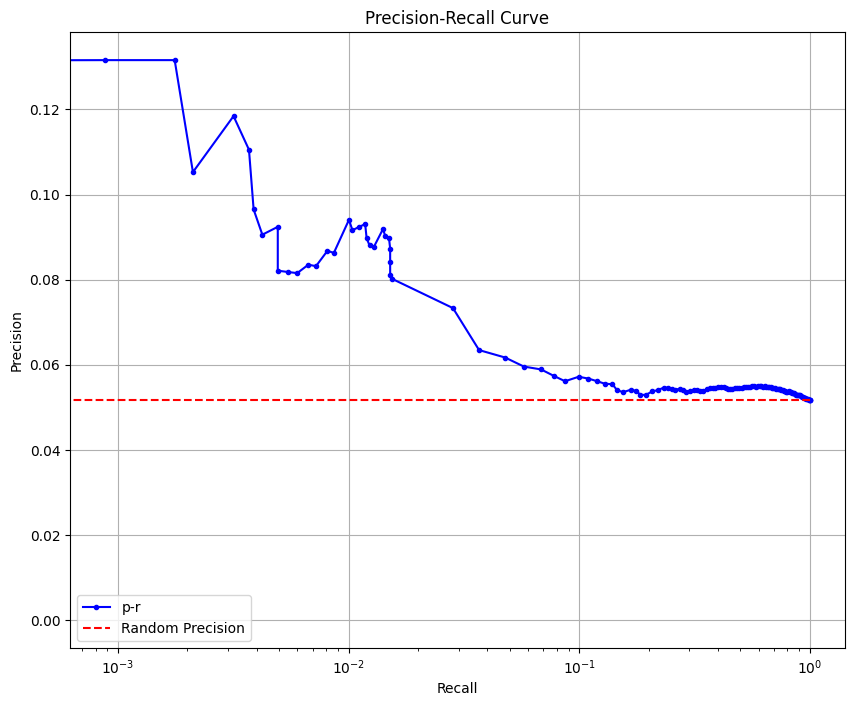

In [23]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]

sc.pp.normalize_total(subadata)
sc.pp.log1p(subadata)
sc.pp.scale(subadata, zero_center=True, max_value=None)
grn = run_deepsem(subadata)
grn.var['symbol'] = make_index_unique(
    grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['deepsem_zhao'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [24]:
metrics

{'deepsem_han': {'precision': 0.027305461092218444,
  'recall': 0.9970119521912351,
  'rand_precision': 0.02738729564094637,
  'auprc': 0.029598807914312943,
  'ap': 0.029699034971487407,
  'epr': 1.5881208305674783},
 'deepsem_han_base': {'TF_enr': False,
  'enriched_terms_Regulators': ['celltype.gmt__Airway goblet cells'],
  'significant_enriched_TFtargets': 18.867924528301888,
  'precision': 0.0015159632226418483,
  'recall': 0.9999068641147434,
  'rand_precision': 0.0015161044263697398,
  'auprc': 0.0018060869702243268,
  'ap': 0.0018883204854496848,
  'epr': 5.54235527488187},
 'deepsem_han_chip': {'precision': 0.2533531096463195,
  'recall': 0.9995187865722205,
  'rand_precision': 0.25347508526095464,
  'auprc': 0.24934405625719908,
  'ap': 0.24940243814610946,
  'epr': 0.9682915492247204},
 'deepsem_han_ko': {'precision': 0.07581693329816405,
  'recall': 0.998577723891907,
  'rand_precision': 0.07592491949717377,
  'auprc': 0.08511216884056125,
  'ap': 0.0852858543727235,
  'epr

In [25]:
import pandas as pd

In [26]:
res = []
res2 = []
for k, v in metrics.items():
    if k.split('_')[-1] == "base":
        res2.append([k.split('_')[-2], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])
    elif k.split('_')[-1] == "ko":
        res.append([k.split('_')[-2]+"_ko", v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])
    elif k.split('_')[-1] == "chip":
        res.append([k.split('_')[-2]+"_chip", v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])
    else:
        res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_only'])
df2 = pd.DataFrame(res2, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

,name,EPR,AUPRC,RAND,TF_only
0,han,1.588121,0.029599,0.027387,False
1,han_chip,0.968292,0.249344,0.253475,False
2,han_ko,1.360083,0.085112,0.075925,False
3,mine,1.001513,0.032512,0.031866,False
4,tran,2.091574,0.063249,0.040543,False
5,tran_chip,1.027675,0.192471,0.198167,False
6,tran_ko,1.582492,0.103110,0.082004,False
7,zhao,1.165549,0.055400,0.051750,False


In [27]:
df2

,name,EPR,AUPRC,RAND,TF_targ,TF_enr,TF_only
0,han,5.542355,0.001806,0.001516,18.867925,False,False
1,mine,0.970661,0.001504,0.001520,7.500000,False,False
2,mine,1.241309,0.001553,0.001520,5.000000,False,False


: 